In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import json # for saving data

In [32]:
# When running in Google Colab, uncomment these
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Set seeds for reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(20221123)
torch.manual_seed(20221123)
random.seed(20221123)

In [3]:
DRIVE_RES_DIR = os.path.join('/content','drive','MyDrive','BsC_Project_Data','Results')
EPOCHS = 25
BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Image transform, perhaps include data augmentation
transform = transforms.Compose([
        #transforms.Resize(224), #REMOVE WHEN EFFICIENTNET
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet specific normalization
        ])

# Load data
Subjects = ["Subject10"]
################################ Google Colab Dir ######################################
data_dir = os.path.join('/content','drive','MyDrive','BsC_Project_Data','T8Colored')
########################################################################################
# data_dir = os.path.join('TFR_plots','T8Colored')
image_datasets = {subject: datasets.ImageFolder(os.path.join(data_dir, subject),
                                          transform) for subject in Subjects}

# Data splitting, different for intra- and inter-subject model.
# Intra subject, Subject 10
dataset = image_datasets["Subject10"]
train_set, val_set = torch.utils.data.random_split(dataset,[292,60])

# Prepare data loader
image_datasets = {"train":train_set, "val":val_set}
dataloaders = {phase: torch.utils.data.DataLoader(image_datasets[phase], batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=4) for phase in ["train", "val"]}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ["train", "val"]}

#class_names = image_datasets["train"].classes
class_names = dataset.classes

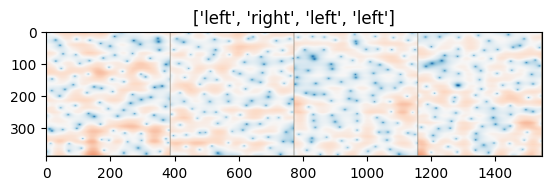

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Store results
    lossvec = {"train":[], "val":[]} 
    accvec = {"train":[], "val":[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            lossvec[phase].append(epoch_loss)
            accvec[phase].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lossvec, accvec

In [ ]:
def GenPlot(epochs,loss,acc,name):
    X = range(epochs)
    fig,ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(X,loss["train"],label="train", color="blue")
    ax[0].plot(X,loss["val"],label="val", color="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].plot(X,acc["train"],label="train", color="blue")
    ax[1].plot(X,acc["val"],label="val", color="red")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    fig.suptitle(name,fontsize=16)
    plt.subplots_adjust(wspace=0.2)

In [ ]:
def saveResults(loss,acc,name,path,model = None):
    partialname = os.path.join(path,name)
    resDict = {name:{"loss":loss,"acc":acc}}
    with open(partialname+".json", 'w', encoding='utf-8') as f:
        json.dump(resDict, f, ensure_ascii=False, indent=4)
    if model:
        torch.save(model.state_dict(), partialname+".pth")

# Train last layer, freeze rest

In [11]:
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
# Freeze weights
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Re-create trainable layer 7
Conv2dNormActivation = nn.Sequential(
    nn.Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False),
    nn.BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    nn.SiLU(inplace=True)
)

# Create new classifier
num_ftrs = model.classifier[1].in_features
classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(num_ftrs, 640),
    nn.Linear(640,2)
)

# Set model trainable parameters
# model.features[7] = Conv2dNormActivation
model.classifier = classifier

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters set after freeze will be trained.
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [54]:
model, loss, acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=EPOCHS)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
name = "PT_EffNet_Freeze"
saveResults(loss,acc,name,DRIVE_RES_DIR)

In [ ]:
GenPlot(EPOCHS,loss,acc,"Pre-Trained EfficientNet_V2_S Frozen")